In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from utils.load_data import load_split
from utils.ml_training import plot_classification_metrics, plot_model_sizes, plot_training_times, run_ml_experiments
from utils.types import FeatureVector_float32, RGBImage_uint8


In [2]:
train_images, train_labels = load_split("data/train/", library="pil")
len(train_images), train_images[0].shape, train_labels.shape


Loading FAKE images: 100%|██████████| 50000/50000 [00:24<00:00, 2036.90it/s]


(100000, (32, 32, 3), (100000,))

In [3]:
test_images, test_labels = load_split("data/test/", library="pil")
len(test_images), test_images[0].shape, test_labels.shape


Loading FAKE images: 100%|██████████| 10000/10000 [00:11<00:00, 834.85it/s]


(20000, (32, 32, 3), (20000,))

In [6]:
COLOR_HIST_BINS = 16


In [64]:
import cv2
import pandas as pd


def extract_color_hist_rgb(img: RGBImage_uint8, color_bins: int) -> pd.DataFrame:
    """Concatenate per-channel normalized histograms."""
    reds = img[..., 0].ravel()
    greens = img[..., 1].ravel()
    blues = img[..., 2].ravel()
    red_hist, _ = np.histogram(reds, bins=color_bins, range=(0, 255), density=True)
    green_hist, _ = np.histogram(greens, bins=color_bins, range=(0, 255), density=True)
    blue_hist, _ = np.histogram(blues, bins=color_bins, range=(0, 255), density=True)
    red_df = pd.DataFrame(red_hist).T.add_prefix("red_hist_")
    green_df = pd.DataFrame(green_hist).T.add_prefix("green_hist_")
    blue_df = pd.DataFrame(blue_hist).T.add_prefix("blue_hist_")
    return pd.concat([red_df, green_df, blue_df], axis=1)


def extract_rgb_histograms_df(images: list[RGBImage_uint8], color_bins: int = COLOR_HIST_BINS) -> pd.DataFrame:
    """Extract RGB histograms for a list of images and return as a DataFrame."""
    histograms = []
    for img in tqdm(images, desc="Extracting RGB histograms"):
        hist_df = extract_color_hist_rgb(img, color_bins)
        histograms.append(hist_df)
    return pd.concat(histograms, ignore_index=True)


df_rgb_train = extract_rgb_histograms_df(train_images)
df_rgb_test = extract_rgb_histograms_df(test_images)

Extracting RGB histograms: 100%|██████████| 20000/20000 [00:12<00:00, 1569.13it/s]


In [65]:
def extract_color_hist_hsv_3d(
    img: RGBImage_uint8,
    h_bins: int = 8,
    s_bins: int = 4,
    v_bins: int = 4,
) -> pd.DataFrame:
    """
    Compute 3D HSV histogram (H x S x V) and return as a labeled DataFrame.
    Example: 8 x 4 x 4 → 128 features with columns: hsv_h0_s0_v0, ...
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[..., 0].astype(np.float32)
    s = hsv[..., 1].astype(np.float32)
    v = hsv[..., 2].astype(np.float32)
    pixels = np.stack([h.ravel(), s.ravel(), v.ravel()], axis=1)
    hist, _ = np.histogramdd(
        pixels,
        bins=(h_bins, s_bins, v_bins),
        range=((0, 180), (0, 256), (0, 256)),
    )
    hist = hist / (hist.sum() + 1e-8)
    flat = hist.flatten()
    columns = [f"hsv_h{hi}_s{si}_v{vi}" for hi in range(h_bins) for si in range(s_bins) for vi in range(v_bins)]
    return pd.DataFrame([flat], columns=columns, dtype=np.float32)


def extract_hsv_histograms_df(
    images: list[RGBImage_uint8],
    h_bins: int = 8,
    s_bins: int = 4,
    v_bins: int = 4,
) -> pd.DataFrame:
    """Loop through images and return a DataFrame of HSV histograms."""
    dfs = [
        extract_color_hist_hsv_3d(img, h_bins, s_bins, v_bins) for img in tqdm(images, desc="Extracting HSV histograms")
    ]
    return pd.concat(dfs, ignore_index=True)


In [66]:
extract_color_hist_hsv_3d(train_images[0])

,hsv_h0_s0_v0,hsv_h0_s0_v1,hsv_h0_s0_v2,hsv_h0_s0_v3,hsv_h0_s1_v0,hsv_h0_s1_v1,hsv_h0_s1_v2,hsv_h0_s1_v3,hsv_h0_s2_v0,hsv_h0_s2_v1,...,hsv_h7_s1_v2,hsv_h7_s1_v3,hsv_h7_s2_v0,hsv_h7_s2_v1,hsv_h7_s2_v2,hsv_h7_s2_v3,hsv_h7_s3_v0,hsv_h7_s3_v1,hsv_h7_s3_v2,hsv_h7_s3_v3
0,0.004883,0.014648,0.043945,0.030273,0.003906,0.010742,0.041016,0.045898,0.008789,0.000977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
df_hsv_train = extract_hsv_histograms_df(train_images)
df_hsv_test = extract_hsv_histograms_df(test_images)

Extracting HSV histograms: 100%|██████████| 20000/20000 [00:25<00:00, 769.92it/s] 


In [68]:
df_color_train = pd.concat([df_rgb_train, df_hsv_train], axis=1)
df_color_train["label"] = train_labels
df_color_test = pd.concat([df_rgb_test, df_hsv_test], axis=1)
df_color_test["label"] = test_labels

In [69]:
df_color_train

,red_hist_0,red_hist_1,red_hist_2,red_hist_3,red_hist_4,red_hist_5,red_hist_6,red_hist_7,red_hist_8,red_hist_9,...,hsv_h7_s1_v3,hsv_h7_s2_v0,hsv_h7_s2_v1,hsv_h7_s2_v2,hsv_h7_s2_v3,hsv_h7_s3_v0,hsv_h7_s3_v1,hsv_h7_s3_v2,hsv_h7_s3_v3,label
0,0.000919,0.001042,0.003493,0.003799,0.005576,0.007292,0.005208,0.004657,0.004779,0.004596,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
1,0.004044,0.003309,0.004902,0.009681,0.011213,0.008150,0.003248,0.001961,0.002145,0.003125,...,0.0,0.000977,0.0,0.0,0.0,0.001953,0.0,0.0,0.0,0
2,0.000245,0.000919,0.001716,0.003248,0.004963,0.007475,0.008578,0.007475,0.008456,0.006495,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
3,0.000613,0.018566,0.007966,0.006005,0.004534,0.003676,0.003922,0.004534,0.002757,0.001593,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
4,0.000000,0.000306,0.002512,0.003370,0.009191,0.018934,0.012255,0.007475,0.002880,0.001103,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.004412,0.002022,0.001961,0.001532,0.002635,0.003064,0.003676,0.003799,0.003922,0.003064,...,0.0,0.000977,0.0,0.0,0.0,0.001953,0.0,0.0,0.0,1
99996,0.005699,0.005699,0.006618,0.007414,0.015870,0.007782,0.004350,0.002267,0.001409,0.001593,...,0.0,0.000977,0.0,0.0,0.0,0.000977,0.0,0.0,0.0,1
99997,0.005392,0.002451,0.002206,0.003064,0.004350,0.004718,0.007230,0.005821,0.002696,0.006924,...,0.0,0.006836,0.0,0.0,0.0,0.002930,0.0,0.0,0.0,1
99998,0.008640,0.011336,0.004963,0.005208,0.005944,0.008333,0.003064,0.001471,0.001961,0.001042,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1


In [70]:
df_color_test

,red_hist_0,red_hist_1,red_hist_2,red_hist_3,red_hist_4,red_hist_5,red_hist_6,red_hist_7,red_hist_8,red_hist_9,...,hsv_h7_s1_v3,hsv_h7_s2_v0,hsv_h7_s2_v1,hsv_h7_s2_v2,hsv_h7_s2_v3,hsv_h7_s3_v0,hsv_h7_s3_v1,hsv_h7_s3_v2,hsv_h7_s3_v3,label
0,0.000429,0.003431,0.003248,0.003554,0.004105,0.002574,0.002757,0.004657,0.006066,0.007292,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0
1,0.005944,0.004534,0.004105,0.003799,0.004779,0.003676,0.004167,0.004534,0.008885,0.006311,...,0.000977,0.007812,0.018555,0.003906,0.0,0.000000,0.011719,0.003906,0.0,0
2,0.001103,0.003983,0.004963,0.005331,0.003248,0.003186,0.005086,0.011458,0.017279,0.005025,...,0.000000,0.006836,0.000977,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0
3,0.000123,0.001716,0.006556,0.007598,0.004657,0.005331,0.005453,0.006556,0.006127,0.007169,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0
4,0.000000,0.001164,0.024449,0.027390,0.006985,0.001961,0.000613,0.000184,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.000000,0.000735,0.005208,0.007047,0.004963,0.005270,0.005882,0.005944,0.005025,0.004841,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1
19996,0.000797,0.002267,0.005760,0.008701,0.011029,0.011949,0.006066,0.005086,0.004412,0.002145,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1
19997,0.001593,0.004963,0.004412,0.004289,0.004779,0.003860,0.003493,0.003860,0.002574,0.004044,...,0.000000,0.003906,0.000000,0.000000,0.0,0.000977,0.000000,0.000000,0.0,1
19998,0.000000,0.001471,0.004350,0.008517,0.006250,0.005576,0.003125,0.000735,0.000306,0.000980,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1


In [76]:
df_color_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 177 entries, red_hist_0 to label
dtypes: float32(128), float64(48), uint8(1)
memory usage: 85.5 MB


In [77]:
df_color_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 177 entries, red_hist_0 to label
dtypes: float32(128), float64(48), uint8(1)
memory usage: 17.1 MB


In [78]:
df_color_train.to_csv("data/color_features_train.csv", index=False)
df_color_test.to_csv("data/color_features_test.csv", index=False)

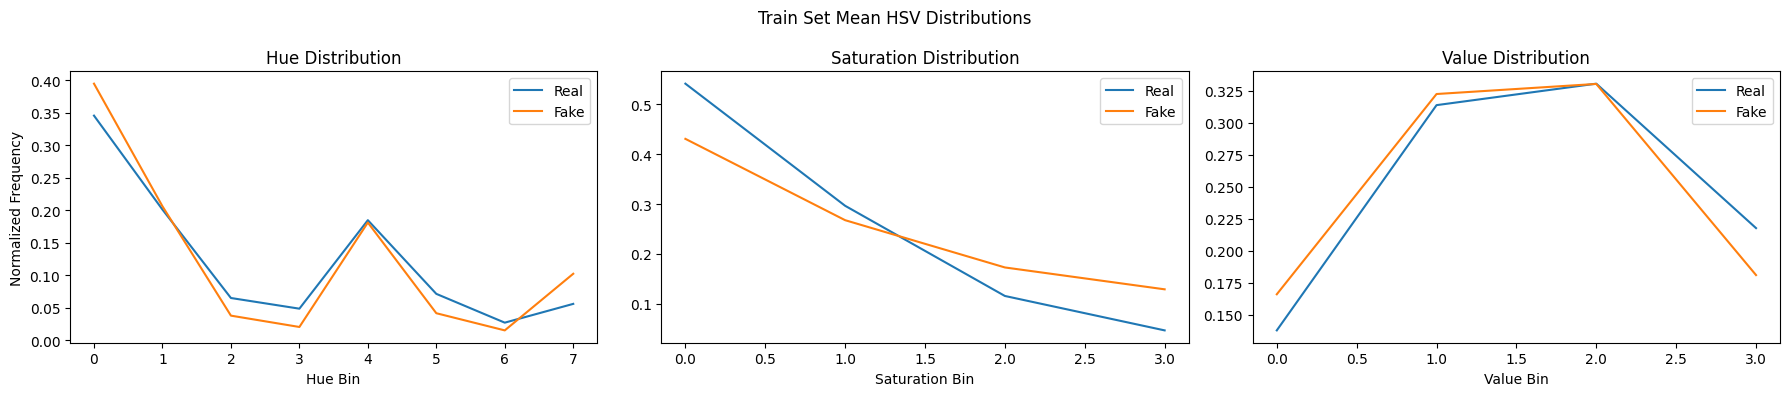

In [61]:
import matplotlib.pyplot as plt
import numpy as np


def plot_mean_hsv_distributions(df, title, h_bins=8, s_bins=4, v_bins=4):
    """
    Plots true Hue, Saturation, and Value distributions by marginalizing
    the 3D HSV histogram (H×S×V) correctly.

    df must contain:
        hsv_h{i}_s{j}_v{k} columns AND a numeric label column.

    label: 0 = real, 1 = fake
    """

    # All histogram columns
    hist_cols = [c for c in df.columns if c.startswith("hsv_h")]

    df_real = df[df["label"] == 0]
    df_fake = df[df["label"] == 1]

    # Convert 128-D vector back into (H,S,V) histogram
    real_mean = df_real[hist_cols].mean().to_numpy().reshape(h_bins, s_bins, v_bins)
    fake_mean = df_fake[hist_cols].mean().to_numpy().reshape(h_bins, s_bins, v_bins)

    # TRUE marginal distributions

    # Hue: sum over S and V  → shape (H,)
    real_hue = real_mean.sum(axis=(1, 2))
    fake_hue = fake_mean.sum(axis=(1, 2))

    # Saturation: sum over H and V → shape (S,)
    real_sat = real_mean.sum(axis=(0, 2))
    fake_sat = fake_mean.sum(axis=(0, 2))

    # Value: sum over H and S → shape (V,)
    real_val = real_mean.sum(axis=(0, 1))
    fake_val = fake_mean.sum(axis=(0, 1))

    # --- Plotting ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Hue
    axs[0].plot(real_hue, label="Real")
    axs[0].plot(fake_hue, label="Fake")
    axs[0].set_title("Hue Distribution")
    axs[0].set_xlabel("Hue Bin")
    axs[0].set_ylabel("Normalized Frequency")
    axs[0].legend()

    # Saturation
    axs[1].plot(real_sat, label="Real")
    axs[1].plot(fake_sat, label="Fake")
    axs[1].set_title("Saturation Distribution")
    axs[1].set_xlabel("Saturation Bin")
    axs[1].legend()

    # Value
    axs[2].plot(real_val, label="Real")
    axs[2].plot(fake_val, label="Fake")
    axs[2].set_title("Value Distribution")
    axs[2].set_xlabel("Value Bin")
    axs[2].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


plot_mean_hsv_distributions(df_color_train, title="Train Set Mean HSV Distributions")

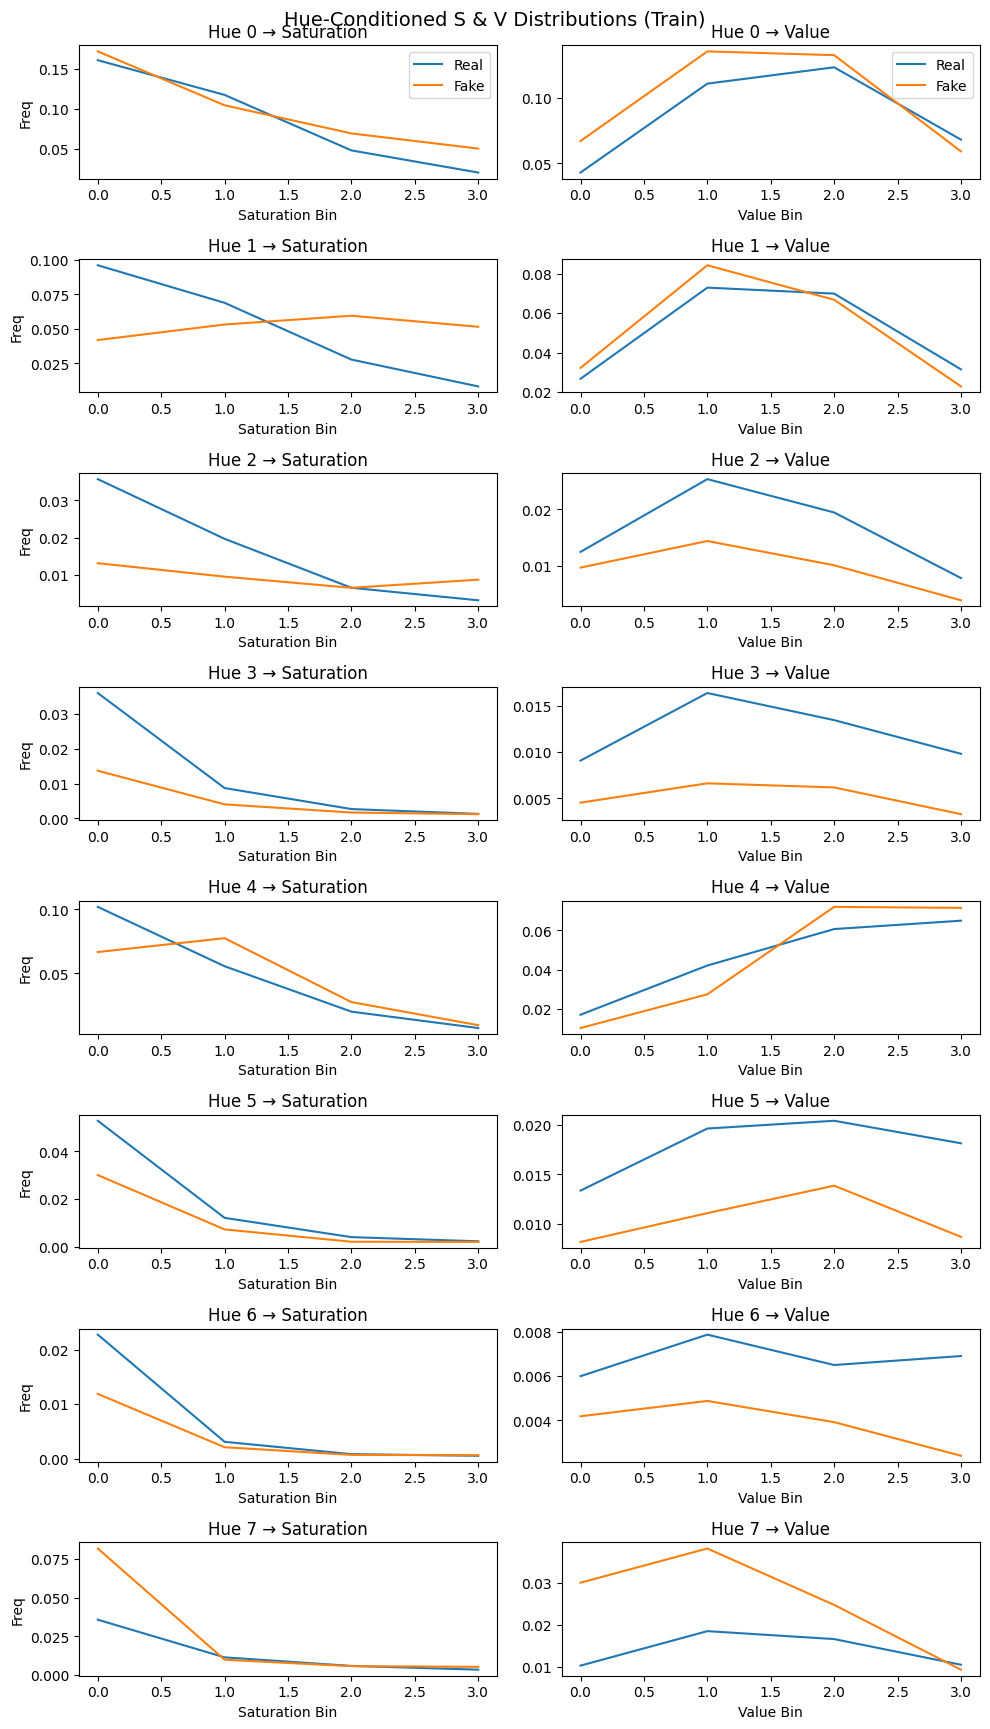

In [62]:
import matplotlib.pyplot as plt
import numpy as np


def plot_hue_conditioned_sv(df, title, h_bins=8, s_bins=4, v_bins=4):
    """
    For each hue bin h, plot:
        1) Saturation distribution conditioned on that Hue (sum over V)
        2) Value distribution conditioned on that Hue (sum over S)

    Produces a grid of H rows × 2 columns.
    """

    # All histogram columns
    hist_cols = [c for c in df.columns if c.startswith("hsv_h")]

    df_real = df[df["label"] == 0]
    df_fake = df[df["label"] == 1]

    # Mean 3D HSV histogram tensors
    real_mean = df_real[hist_cols].mean().to_numpy().reshape(h_bins, s_bins, v_bins)
    fake_mean = df_fake[hist_cols].mean().to_numpy().reshape(h_bins, s_bins, v_bins)

    fig, axs = plt.subplots(h_bins, 2, figsize=(10, 2.2 * h_bins))

    if h_bins == 1:
        axs = np.array([axs])

    for h in range(h_bins):
        # Saturation distribution conditioned on hue h:
        # sum over V → shape (S,)
        real_sat = real_mean[h].sum(axis=1)
        fake_sat = fake_mean[h].sum(axis=1)

        # Value distribution conditioned on hue h:
        # sum over S → shape (V,)
        real_val = real_mean[h].sum(axis=0)
        fake_val = fake_mean[h].sum(axis=0)

        # --- Plot Saturation ---
        ax_s = axs[h, 0]
        ax_s.plot(real_sat, label="Real")
        ax_s.plot(fake_sat, label="Fake")
        ax_s.set_title(f"Hue {h} → Saturation")
        ax_s.set_xlabel("Saturation Bin")
        ax_s.set_ylabel("Freq")

        # --- Plot Value ---
        ax_v = axs[h, 1]
        ax_v.plot(real_val, label="Real")
        ax_v.plot(fake_val, label="Fake")
        ax_v.set_title(f"Hue {h} → Value")
        ax_v.set_xlabel("Value Bin")

        if h == 0:
            ax_s.legend()
            ax_v.legend()

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# Usage
plot_hue_conditioned_sv(df_color_train, "Hue-Conditioned S & V Distributions (Train)")


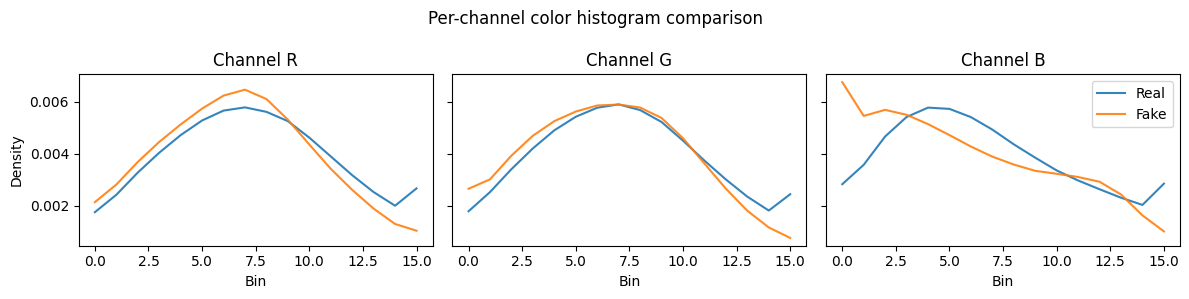

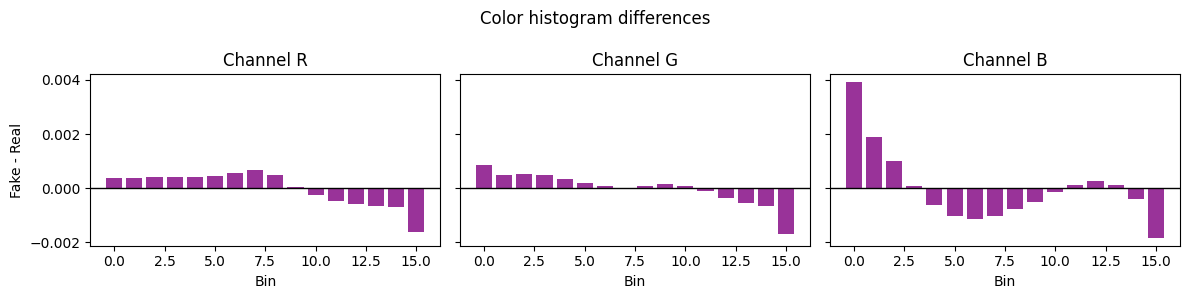

In [9]:
def _reshape_hist(vec: FeatureVector_float32) -> np.ndarray:
    return vec.reshape(3, COLOR_HIST_BINS)


def plot_color_histograms(real_hist: FeatureVector_float32, fake_hist: FeatureVector_float32) -> None:
    channels = ["R", "G", "B"]
    real = _reshape_hist(real_hist)
    fake = _reshape_hist(fake_hist)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    for idx, ax in enumerate(axes):
        ax.plot(real[idx], label="Real", alpha=0.9)
        ax.plot(fake[idx], label="Fake", alpha=0.9)
        ax.set_title(f"Channel {channels[idx]}")
        ax.set_xlabel("Bin")
    axes[0].set_ylabel("Density")
    axes[-1].legend()
    fig.suptitle("Per-channel color histogram comparison")
    fig.tight_layout()
    plt.show()


def plot_color_hist_diff(real_hist: FeatureVector_float32, fake_hist: FeatureVector_float32) -> None:
    diff = _reshape_hist(fake_hist - real_hist)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    channels = ["R", "G", "B"]
    for idx, ax in enumerate(axes):
        ax.bar(np.arange(COLOR_HIST_BINS), diff[idx], color="purple", alpha=0.8)
        ax.axhline(0, color="black", linewidth=1)
        ax.set_title(f"Channel {channels[idx]}")
        ax.set_xlabel("Bin")
    axes[0].set_ylabel("Fake - Real")
    fig.suptitle("Color histogram differences")
    fig.tight_layout()
    plt.show()


plot_color_histograms(real_color_hist, fake_color_hist)
plot_color_hist_diff(real_color_hist, fake_color_hist)


In [73]:
X_train = df_color_train.drop(columns=["label"]).to_numpy(dtype=np.float32)
y_train = df_color_train["label"].to_numpy()
X_test = df_color_test.drop(columns=["label"]).to_numpy(dtype=np.float32)
y_test = df_color_test["label"].to_numpy()


In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((100000, 128), (20000, 128), (100000,), (20000,))

In [42]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype


(dtype('float32'), dtype('float32'), dtype('uint8'), dtype('uint8'))

In [74]:
rng = np.random.RandomState(42)
shuffle_indices = rng.permutation(len(X_train))
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]


In [44]:
path_output = Path("outputs/color_classification_results.json")
results = run_ml_experiments(X_train, y_train, X_test, y_test, path_output)



GaussianNB:
Training time: 0.06 seconds
              precision    recall  f1-score   support

        Real     0.7401    0.4406    0.5524     10000
        Fake     0.6018    0.8453    0.7030     10000

    accuracy                         0.6430     20000
   macro avg     0.6709    0.6430    0.6277     20000
weighted avg     0.6709    0.6430    0.6277     20000

Model size (joblib): 0.003 MB

KNeighborsClassifier:
Training time: 0.01 seconds
              precision    recall  f1-score   support

        Real     0.7644    0.7713    0.7678     10000
        Fake     0.7692    0.7623    0.7657     10000

    accuracy                         0.7668     20000
   macro avg     0.7668    0.7668    0.7668     20000
weighted avg     0.7668    0.7668    0.7668     20000

Model size (joblib): 4.997 MB

LogisticRegression:
Training time: 10.08 seconds
              precision    recall  f1-score   support

        Real     0.7254    0.7955    0.7588     10000
        Fake     0.7736    0.6988  

d:\AT82.08-AI-Generated-Image-Classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [75]:
results = run_ml_experiments(X_train, y_train, X_test, y_test, path_output)


GaussianNB:
Training time: 0.09 seconds
              precision    recall  f1-score   support

        Real     0.7589    0.4818    0.5894     10000
        Fake     0.6204    0.8469    0.7162     10000

    accuracy                         0.6643     20000
   macro avg     0.6896    0.6643    0.6528     20000
weighted avg     0.6896    0.6643    0.6528     20000

Model size (joblib): 0.003 MB

KNeighborsClassifier:
Training time: 0.01 seconds
              precision    recall  f1-score   support

        Real     0.7671    0.7735    0.7703     10000
        Fake     0.7716    0.7652    0.7684     10000

    accuracy                         0.7693     20000
   macro avg     0.7694    0.7693    0.7693     20000
weighted avg     0.7694    0.7693    0.7693     20000

Model size (joblib): 11.931 MB

LogisticRegression:
Training time: 7.05 seconds
              precision    recall  f1-score   support

        Real     0.7299    0.7968    0.7619     10000
        Fake     0.7763    0.7052  

d:\AT82.08-AI-Generated-Image-Classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


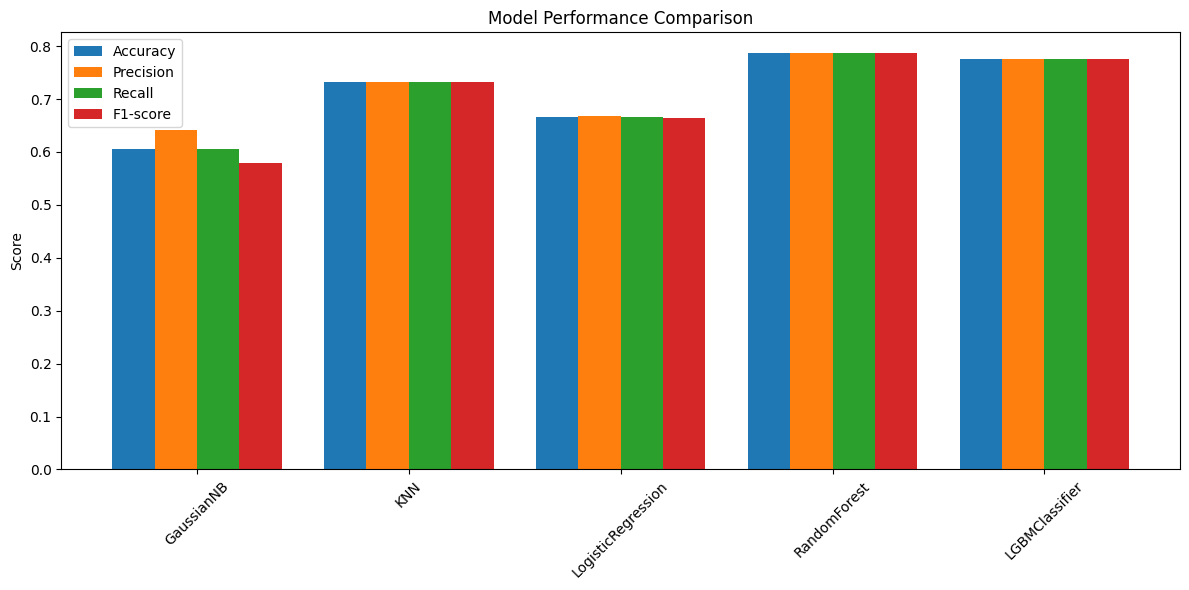

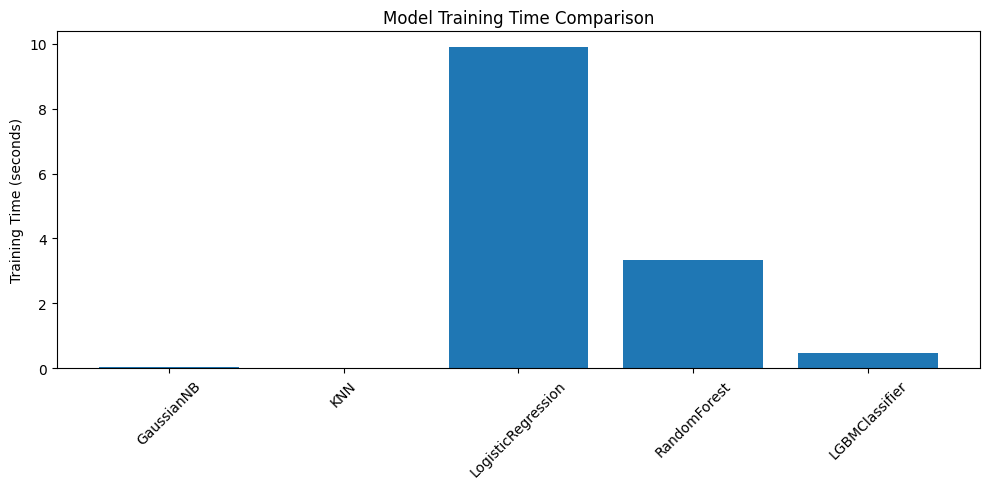

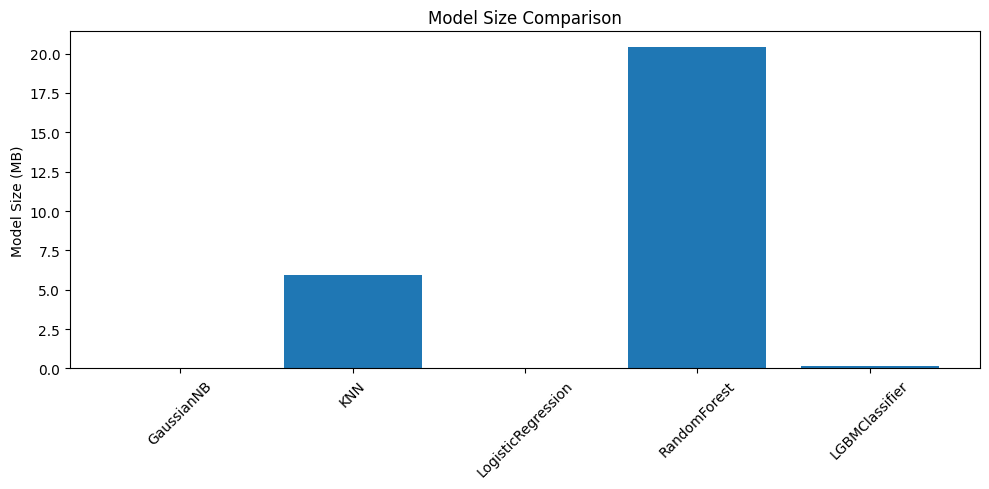

In [15]:
plot_classification_metrics(results)
plot_training_times(results)
plot_model_sizes(results)
